In [1]:
from pathlib import Path
import os
os.chdir("..")

In [2]:
import lovely_tensors as lt
lt.monkey_patch()

In [69]:

import pickle
from einops import rearrange, repeat
import pandas as pd
import torch
import torch.nn.functional as F
from torchvision.transforms import functional as TvT
import torch.nn as nn
import numpy as np
from PIL import Image
from torchmetrics import F1Score, MetricCollection
from torchvision.transforms.functional import resize
import torch.optim.lr_scheduler as lr_scheduler


import numpy as np
import torch

from fssweed.utils.utils import ResultDict, StrEnum, torch_dict_load, torch_dict_save, to_device
from fssweed.models import build_model
from fssweed.data import get_preprocessing, get_testloaders
from fssweed.data.utils import (
    AnnFileKeys,
    PromptType,
    BatchKeys,
    sum_scale,
    min_max_scale,
)
from fssweed.substitution import Substitutor
import matplotlib.pyplot as plt
from tqdm import tqdm

In [4]:
def create_rgb_segmentation(segmentation, num_classes=None):
    """
    Convert a segmentation map to an RGB visualization using a precise colormap.

    Args:
        segmentation (torch.Tensor): Segmentation map of shape [B, H, W] where
                                      each pixel contains class labels (natural numbers).
        num_classes (int): The number of unique classes in the segmentation.

    Returns:
        torch.Tensor: RGB visualization of shape [B, 3, H, W].
    """
    if len(segmentation.shape) == 4:
        segmentation = segmentation.argmax(dim=1)
    if num_classes is None:
        num_classes = segmentation.max().item() + 1
    
    # Define a precise colormap for specific classes
    colormap = torch.tensor([
        [0, 0, 0],       # Class 0: Black (Background)
        [0, 128, 0],     # Class 2: Green
        [128, 0, 0],     # Class 1: Red
        [128, 128, 0],   # Class 3: Yellow
        [0, 0, 128],     # Class 4: Blue
        [128, 0, 128],   # Class 5: Magenta
        [0, 128, 128],   # Class 6: Cyan
        [192, 192, 192], # Class 7: Light Gray
    ], dtype=torch.uint8)  # Ensure dtype is uint8

    # Initialize an empty tensor for RGB output
    B, H, W = segmentation.shape
    rgb_segmentation = torch.zeros((B, 3, H, W), dtype=torch.uint8)

    # Loop through each class and assign the corresponding RGB color
    for class_id in range(num_classes):
        # Create a mask for the current class
        class_mask = (segmentation == class_id).unsqueeze(1)  # Shape: [B, 1, H, W]
        # Assign the corresponding color to the rgb_segmentation
        rgb_segmentation += class_mask * colormap[class_id].view(1, 3, 1, 1)  # Broadcasting

    return rgb_segmentation

def unnormalize(tensor, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    """
    Unnormalize a tensor image with mean and standard deviation.
    
    Args:
        tensor (torch.Tensor): Tensor image of size [B, 3, H, W] to be unnormalized.
        mean (list or tuple): Mean for each channel.
        std (list or tuple): Standard deviation for each channel.
    
    Returns:
        torch.Tensor: Unnormalized tensor image.
    """
    # Ensure the mean and std are tensors and have the correct shape
    mean = torch.tensor(mean, dtype=tensor.dtype, device=tensor.device).view(1, 3, 1, 1)
    std = torch.tensor(std, dtype=tensor.dtype, device=tensor.device).view(1, 3, 1, 1)
    
    # Unnormalize the tensor
    tensor = tensor * std + mean
    
    return tensor

def batch_visualizer(batch, gt, pred=None):
    assert batch[BatchKeys.PROMPT_MASKS].shape[0] == 1
    masks = batch[BatchKeys.PROMPT_MASKS][0]
    images = batch[BatchKeys.IMAGES][0]
    num_classes = masks.shape[1]
    masks = masks.argmax(dim=1)
    masks = create_rgb_segmentation(masks.cpu(), num_classes=num_classes)
    drawn_gt = create_rgb_segmentation(gt.cpu(), num_classes=num_classes)
    images = torch.cat([unnormalize(image) for image in images]).cpu()
    images = resize(images, gt.shape[-2:])
    masks = torch.cat([drawn_gt, masks], dim=0)
    drawn_batch = torch.stack([images, masks], dim=1)
    if pred is not None:
        drawn_pred = create_rgb_segmentation(pred.cpu(), num_classes=num_classes)
        padding = torch.ones_like(images.unsqueeze(1))
        padding[0] = drawn_pred
        drawn_batch = torch.cat([drawn_batch, padding], dim=1)
    drawn_batch = rearrange(drawn_batch, 'b t c h w -> b c h (t w)')
    return drawn_batch
    
def scale(tensor):
    return (tensor - tensor.min()) / (tensor.max() - tensor.min())

def scale_neg(tensor):
    return 2 * (tensor - tensor.min()) / (tensor.max() - tensor.min()) - 1

def scale_pos_neg(tensor):
    min_val = tensor.min()
    max_val = tensor.max()
    
    pos_mask = tensor > 0
    neg_mask = tensor < 0
    
    scaled_tensor = torch.zeros_like(tensor, dtype=tensor.dtype)

    # Scale positive values
    if pos_mask.any():
        scaled_tensor[pos_mask] = tensor[pos_mask] / max_val

    # Scale negative values
    if neg_mask.any():
        scaled_tensor[neg_mask] = tensor[neg_mask] / abs(min_val)

    return scaled_tensor

def normalize(tensor):
    mean = tensor.mean()
    std = tensor.std()
    normalized_tensor = (tensor - mean) / std
    return normalized_tensor

In [78]:
parameters = {
    'dataloader': {'num_workers': 0}, 
    'dataset': {
        'preprocess': {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225], 'image_size': 384},
        'datasets': {
            'test_weedmap': {
                'train_root': '../Datasets/WeedMap/0_rotations_processed_003_test/RedEdge/000',
                'test_root': '../Datasets/WeedMap/0_rotations_processed_003_test/RedEdge/003',
                'prompt_images': [
                    # 'frame0009_2.png',
                    # 'frame0021_2.png',
                    'frame0033_3.png',
                    # 'frame0034_1.png',
                    # 'frame0048_0.png',
                    ],
                'remove_black_images': False}
            },
    },
    'model': {
        'name': 'dcama',
        'backbone': 'swin',
        'backbone_checkpoint': 'checkpoints/swin_base_patch4_window12_384.pth',
        'model_checkpoint': 'checkpoints/swin_fold0_pascal_modcross_soft.pt',
        # 'model_checkpoint': "checkpoints/swin_fold0.pt",
        'concat_support': False,
        'image_size': 384,
        'train_backbone': True,
        "pe": False,
        }, 
    'refinement': {'lr': 0.01, 'max_iterations': 1000}
}

In [79]:
def exg_refine(image, threshold, prediction):
    img = resize(image, prediction.shape[-2:])
    exg = 2*img[:, 1] - img[:, 0] + img[:, 2]
    exg_mask = ((exg - exg.min())/(exg.max() - exg.min()) > threshold)
    return (exg_mask*prediction) 


In [80]:
preprocess = get_preprocessing(parameters["dataset"])

### Get WeedMap

In [81]:
test_loaders = get_testloaders(
        parameters["dataset"],
        parameters["dataloader"]
    )
weedmap = test_loaders["test_weedmap"]

In [82]:
class FocalLoss(nn.Module):
    def __init__(
        self, gamma: float = 2.0, weights=None
    ):
        super().__init__()
        self.gamma = gamma
        self.weights = weights

        self.reduction = torch.mean

    def __call__(self, x, target):
        ce_loss = F.cross_entropy(x, target, reduction="none")
        pt = torch.exp(-ce_loss)
        
        if self.weights is not None:
            weights = self.weights.to(x.device)[target]
            focal_loss = torch.pow((1 - pt), self.gamma) * weights * ce_loss
        else:
            focal_loss = torch.pow((1 - pt), self.gamma) * ce_loss

        return self.reduction(focal_loss)

### Get Model

In [83]:
device = "cpu"
model = build_model(parameters["model"])
model.to(device)
model.eval()

Removing pe from state_dict


DCAMAMultiClass(
  (feature_extractor): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0): BasicLayer(
        dim=128, input_resolution=(96, 96), depth=2
        (blocks): ModuleList(
          (0): SwinTransformerBlock(
            dim=128, input_resolution=(96, 96), num_heads=4, window_size=12, shift_size=0, mlp_ratio=4.0
            (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              dim=128, window_size=(12, 12), num_heads=4
              (qkv): Linear(in_features=128, out_features=384, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=128, out_features=128, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax)

In [84]:
state_dict = torch.load("checkpoints/f4z7ghu7.pt")
model.load_state_dict(state_dict)

RuntimeError: Error(s) in loading state_dict for DCAMAMultiClass:
	Unexpected key(s) in state_dict: "model.pe.0.pe", "model.pe.1.pe", "model.pe.2.pe". 

### Get the training data

In [ ]:
examples = weedmap.dataset.extract_prompts()
examples = to_device(examples, device)

def get_support_batch(examples):
    support_batch = {
        BatchKeys.IMAGES: examples[BatchKeys.IMAGES].unsqueeze(0).clone(),
        BatchKeys.PROMPT_MASKS: examples[BatchKeys.PROMPT_MASKS].unsqueeze(0).clone(),
        BatchKeys.FLAG_MASKS: examples[BatchKeys.FLAG_MASKS].unsqueeze(0).clone(),
        BatchKeys.FLAG_EXAMPLES: examples[BatchKeys.FLAG_EXAMPLES].unsqueeze(0).clone(),
        BatchKeys.DIMS: examples[BatchKeys.DIMS].unsqueeze(0).clone()
    }
    support_gt = examples[BatchKeys.PROMPT_MASKS].argmax(dim=1).unsqueeze(0)
    return support_batch, support_gt

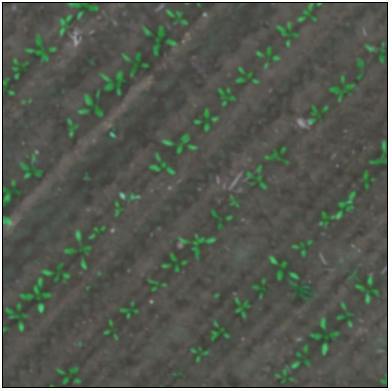

In [ ]:
unnormalize(examples[BatchKeys.IMAGES]).rgb

### Qualitative test

In [ ]:
iterator = iter(weedmap)

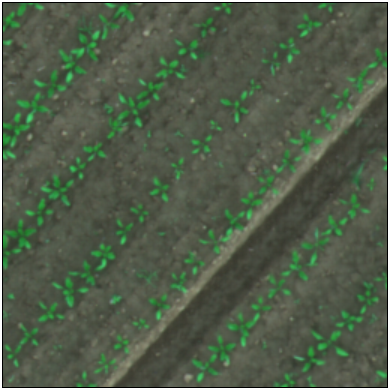

In [ ]:
batch_dict  = next(iterator)
unnormalize(batch_dict[0][BatchKeys.IMAGES][:, 0]).rgb

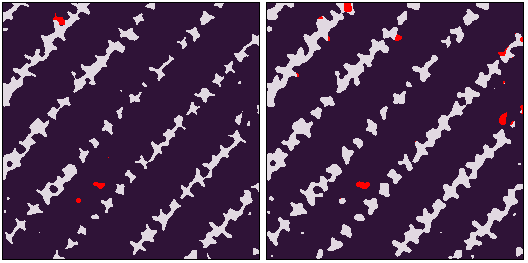

In [85]:
from fssweed.data.utils import merge_dicts

image_dict, gt = batch_dict
input_dict = to_device(merge_dicts(prompts=examples, imgs=image_dict), device)
gt = to_device(gt, device)
with torch.no_grad():
    result = model(input_dict)
outputs = torch.argmax(result[ResultDict.LOGITS], dim=1)

torch.cat([gt, outputs], dim=0).chans

In [86]:
image_dict

{<BatchKeys.IMAGES: 'images'>: tensor[1, 1, 3, 384, 384] n=442368 (1.7Mb) x∈[-1.553, 1.746] μ=-0.600 σ=0.285,
 <BatchKeys.DIMS: 'dims'>: tensor[1, 2] i64 μ=256.000 σ=0. [[256, 256]]}

In [87]:
attns_class = result[ResultDict.ATTENTIONS]
masks = input_dict[BatchKeys.PROMPT_MASKS]
flag_examples = input_dict[BatchKeys.FLAG_EXAMPLES]
shape = image_dict[BatchKeys.IMAGES].shape[-2:]
query = image_dict[BatchKeys.IMAGES][:, 0]


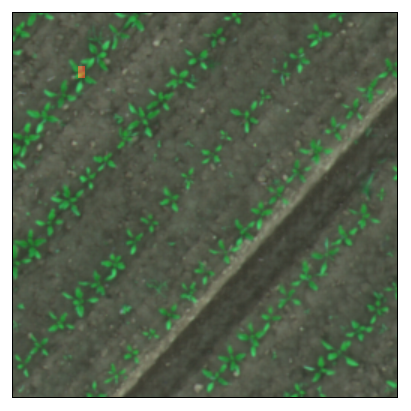

In [88]:
# rect = torch.tensor([0.2, 0.2, 0.25, 0.25]).float()
rect = torch.tensor([0.14, 0.17, 0.17, 0.19]).float()
selected_zone = torch.zeros(shape, dtype=torch.bool).unsqueeze(0)

# rescale rect
rect = (rect * torch.tensor([shape, shape]).flatten()).long()
selected_zone[:, rect[0]:rect[2], rect[1]:rect[3]] = 1
to_show = query.clone()
to_show[:, 0, rect[0]:rect[2], rect[1]:rect[3]] = 1
unnormalize(to_show).rgb.fig

In [89]:
model.model.pe

ModuleList(
  (0-2): 3 x Identity()
)

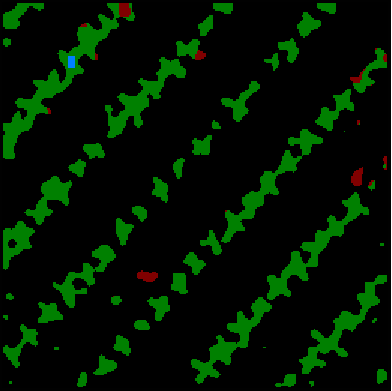

In [90]:
seg = resize(create_rgb_segmentation(result[ResultDict.LOGITS].argmax(dim=1), num_classes=3), shape, interpolation=TvT.InterpolationMode.NEAREST)
seg[:, 2, rect[0]:rect[2], rect[1]:rect[3]] = 255
seg.rgb

In [91]:
selected_x = 56
selected_y = 65

tensor[22, 1, 384, 384] n=3244032 (12Mb) x∈[0., 0.410] μ=0.002 σ=0.008


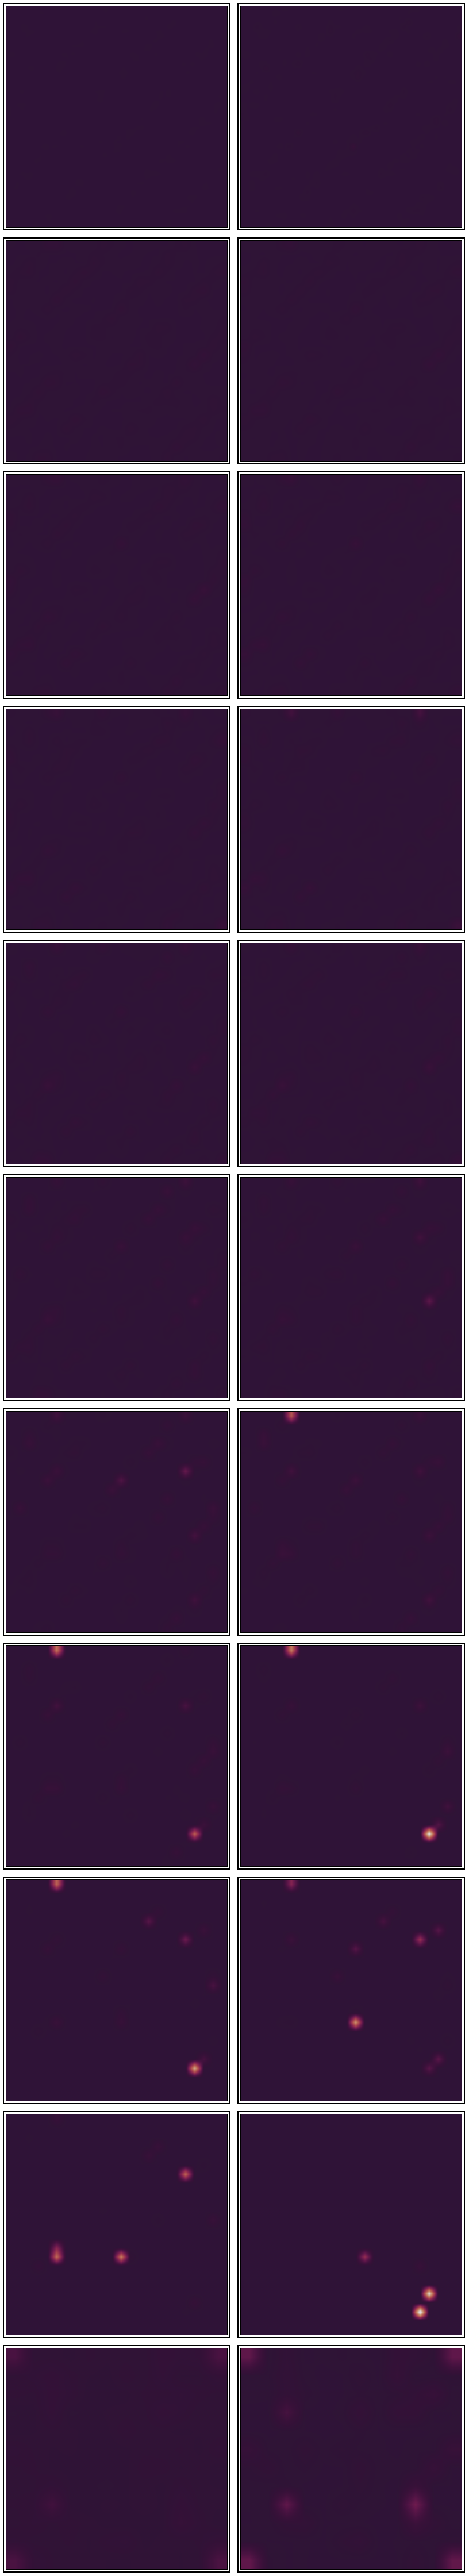

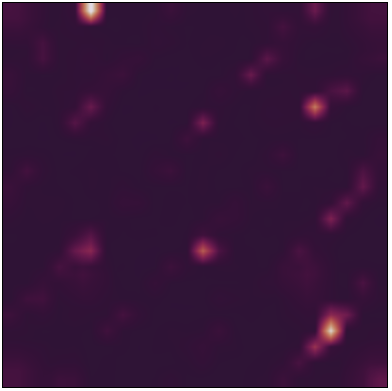

In [92]:
chosen_class = 0
chosen_level = 2

attns = result[ResultDict.ATTENTIONS]
masks = input_dict[BatchKeys.PROMPT_MASKS]
flag_examples = input_dict[BatchKeys.FLAG_EXAMPLES]

class_attns = attns_class[chosen_class]

class_examples = flag_examples[:, :, chosen_class + 1]
mask = masks[:, :, chosen_class+1, ::][class_examples]
result_mask = (result[ResultDict.LOGITS].argmax(dim=1) == chosen_class+1)

level_contributions = []
for level_attn in class_attns:

    level_attn = level_attn.mean(dim=1)

    hw = level_attn.shape[-2]
    h = w = int(hw ** 0.5)
    mask_current = resize(mask, (h, w), interpolation=TvT.InterpolationMode.NEAREST)
    mask_current = rearrange(mask_current, "n h w -> 1 1 n (h w)")
    level_attn = F.softmax(level_attn, dim=-1)
    level_attn = rearrange(level_attn, "b (h1 w1) (n h2 w2) -> (b h2 w2 n) h1 w1", n=mask_current.shape[2], h1=h, w1=w, h2=h, w2=w)
    level_attn = resize(level_attn, selected_zone.shape[1:])
    level_attn = level_attn[:, selected_y, selected_x]
    level_attn = rearrange(level_attn, "(b h2 w2 n) -> (b n) h2 w2", h2=h, w2=w, n=mask_current.shape[2])
    resized_level_attn = resize(level_attn, selected_zone.shape[1:], interpolation=TvT.InterpolationMode.BILINEAR, antialias=False)
    level_contributions.append(resized_level_attn)

contrib_seq = torch.stack(level_contributions)
contrib = contrib_seq.mean(dim=0)
print(contrib_seq)
display(scale(contrib_seq).chans)
display(scale(contrib).chans)

In [58]:
from captum.attr import LayerGradCam, FeatureAblation, LayerActivation, LayerAttribution, IntegratedGradients

In [93]:
selected_x = 56
selected_y = 65
query_feats = result[ResultDict.QUERY_FEATS][chosen_class]
attentions = result[ResultDict.ATTENTIONS][chosen_class]
expl_input = tuple(result[ResultDict.COARSE_MASKS][chosen_class])
masks = input_dict[BatchKeys.PROMPT_MASKS]
flag_examples = input_dict[BatchKeys.FLAG_EXAMPLES]
class_examples = flag_examples[:, :, chosen_class + 1]
mask = masks[:, :, chosen_class+1, ::][class_examples]

for attn in attentions:
    attn.required_grad = True
attentions = tuple(attentions)

In [94]:
import math
from fssweed.models.dcama.dcama import stack_and_reshape_features

def pred_layer(model, coarse_masks1, coarse_masks2, coarse_masks3, query_feats):
    mix = model.model.mix_maps(coarse_masks1, coarse_masks2, coarse_masks3)
    mix, _, _ = model.model.skip_concat_features(mix, query_feats, None, None)
    logit_mask, _, _ = model.model.upsample_and_classify(mix)
    return logit_mask

def attention_pred_layer(*inputs):
    attentions = inputs[:-2]
    support_masks = inputs[-1]
    query_feats = inputs[-2]
    
    coarse_masks = []
    for attn in attentions:
        attn = F.softmax(attn, dim=-1)
        shape = attn.shape[-2]
        h = w = int(math.sqrt(shape))
        resized_mask = resize(support_masks, size=(h, w), interpolation=TvT.InterpolationMode.NEAREST)
        resized_mask = repeat(resized_mask, "b h w -> (b he) (h w) 1", he=attn.shape[1])
        out = attn @ resized_mask
        out = out.mean(dim=1)
        out = rearrange(out, "b (h w) 1 -> b 1 h w", h=h)
        coarse_masks.append(out)
    coarse_masks1 = stack_and_reshape_features(coarse_masks, model.stack_ids, model.stack_ids[2], model.stack_ids[3])
    coarse_masks2 = stack_and_reshape_features(coarse_masks, model.stack_ids, model.stack_ids[1], model.stack_ids[2])
    coarse_masks3 = stack_and_reshape_features(coarse_masks, model.stack_ids, model.stack_ids[0], model.stack_ids[1])
    return pred_layer(coarse_masks1, coarse_masks2, coarse_masks3, query_feats)

def seg_wrapper(coarse_masks1, coarse_masks2, coarse_masks3, query_feats):
    x = pred_layer(coarse_masks1, coarse_masks2, coarse_masks3, query_feats)
    pixel = x[:, :, selected_x, selected_y]
    return pixel

def attention_seg_wrapper(*inputs):
    x = attention_pred_layer(*inputs)
    pixel = x[:, :, selected_x, selected_y]
    return pixel

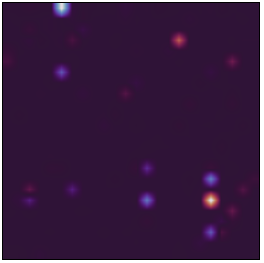

In [29]:
explainer = IntegratedGradients(attention_seg_wrapper)
gc_attr = explainer.attribute(attentions, additional_forward_args=(query_feats, mask), target=1, n_steps=1)
aggr_gc_attr = [attr.mean(dim=1).sum(dim=1) for attr in gc_attr]

max_value = max(v.max() for v in aggr_gc_attr)
min_value = min(v.min() for v in aggr_gc_attr)
norm_gc_attr = [(gc - min_value) / (max_value - min_value) for gc in aggr_gc_attr]

target_size = 256

resized_attr = []
for attr in aggr_gc_attr:
    shape = attr.shape[-1]
    h = w = int(math.sqrt(shape))
    attr = rearrange(attr, "1 (h w) -> 1 h w", h=h)
    attr = resize(attr, size=(target_size, target_size), interpolation=TvT.InterpolationMode.BILINEAR)
    resized_attr.append(attr)
resized_attr = torch.stack(resized_attr, dim=1).sum(dim=1)
scale_pos_neg(resized_attr).chans

In [97]:
def feature_ablation(model, result, chosen_class, selected_x, selected_y):
    query_feats = result[ResultDict.QUERY_FEATS][chosen_class]
    coarse_masks = tuple(result[ResultDict.COARSE_MASKS][chosen_class])
    with torch.no_grad():
        orig_out = pred_layer(model, *coarse_masks, query_feats)[:, :, selected_x, selected_y]
    diffs = []
    for i in range(len(coarse_masks)):
        for j in range(coarse_masks[i].shape[1]):
            new_input = coarse_masks[i].clone()
            new_input[:, j] = 0
            new_expl_input = [*coarse_masks[0:i], *[new_input], *coarse_masks[i+1:]]
            with torch.no_grad():
                new_out = pred_layer(model, *new_expl_input, query_feats)[:, :, selected_x, selected_y]
            diffs.append(orig_out - new_out)
    
    abl_attr = sum_scale(torch.stack([torch.abs(diff[0, 1]) for diff in diffs]))
    return abl_attr

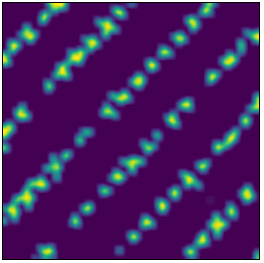

In [112]:
TvT.gaussian_blur((2*mask-1), (9,9), sigma=5).chans(cmap="viridis")

In [100]:
feature_ablation(model, result, 0, 56, 65).p

tensor([1.0085e-02, 7.4981e-03, 7.3944e-03, 5.0527e-03, 2.9813e-03, 3.3720e-03,
        7.3914e-04, 2.0481e-03, 8.1209e-04, 1.0224e-03, 3.4678e-04, 2.5812e-03,
        3.3419e-03, 3.9912e-03, 4.2825e-03, 1.7416e-03, 5.4284e-03, 5.8858e-03,
        5.3353e-03, 5.4048e-03, 8.5100e-03, 9.1215e-01])

In [76]:
tuple(result[ResultDict.COARSE_MASKS][chosen_class])

(tensor[1, 2, 12, 12] n=288 (1.1Kb) all_zeros,
 tensor[1, 18, 24, 24] n=10368 (40Kb) x∈[0., 0.073] μ=0.001 σ=0.003,
 tensor[1, 2, 48, 48] n=4608 (18Kb) x∈[1.053e-07, 0.006] μ=0.000 σ=0.001)

In [63]:
orig_out = seg_wrapper(*expl_input, query_feats)
diffs = []
for i in range(len(expl_input)):
    for j in range(expl_input[i].shape[1]):
        new_input = expl_input[i].clone()
        new_input[:, j] = 0
        new_expl_input = [*expl_input[0:i], *[new_input], *expl_input[i+1:]]
        new_out = seg_wrapper(*new_expl_input, query_feats)
        diffs.append(orig_out - new_out)

In [ ]:

sum_scale(torch.stack([torch.abs(diff[0, 1]) for diff in diffs])).p

tensor([0.0000, 0.0000, 0.0008, 0.0067, 0.0008, 0.0003, 0.0030, 0.0202, 0.0219,
        0.0349, 0.0431, 0.0660, 0.0388, 0.0516, 0.0549, 0.0441, 0.0625, 0.1711,
        0.1005, 0.2763, 0.0023, 0.0003], grad_fn=<DivBackward0>)

In [32]:
abl_attr = scale(torch.stack([torch.abs(diff).sum().detach() for diff in diffs]))

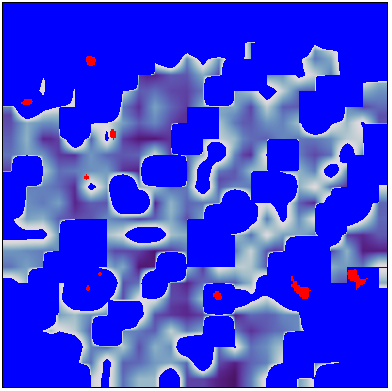

In [53]:
weighted_attr = torch.cat([contrib_seq[i] * abl_attr[i] for i in range(abl_attr.shape[0])], dim=0).sum(dim=0)
resize_mask = resize(mask, weighted_attr.shape[-2:], interpolation=TvT.InterpolationMode.NEAREST)
pos_weighted_attr = torch.log(scale(weighted_attr * resize_mask)+1e-6)
neg_weighted_attr = torch.log(scale(weighted_attr * (1 - resize_mask))+1e-6)
(pos_weighted_attr + neg_weighted_attr*-1).chans

In [108]:
explainer = IntegratedGradients(seg_wrapper)
gc_attr = explainer.attribute(expl_input, additional_forward_args=(query_feats), target=1, n_steps=1)
coarse_attr = torch.cat([torch.abs(attr).sum(dim=(2, 3)) for attr in gc_attr], dim=1)

In [136]:
coarse_attr.p

tensor([[0.0000, 0.0000, 0.0026, 0.0025, 0.0003, 0.0002, 0.0006, 0.0026, 0.0044,
         0.0057, 0.0068, 0.0108, 0.0050, 0.0063, 0.0068, 0.0062, 0.0123, 0.0540,
         0.0257, 0.0567, 0.0061, 0.0002]], dtype=torch.float64)

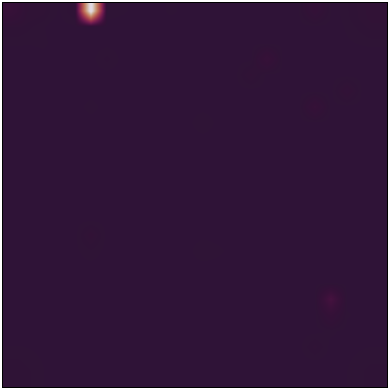

In [109]:
scale(torch.cat([contrib_seq[i] * coarse_attr[:, i] for i in range(coarse_attr.shape[1])], dim=0).sum(dim=0)).chans